# Randomized Optimization
1. Randomized hill climbing
2. Simulated annealing
3. Genetic algorithm
4. MIMIC

## Import packages

In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import matplotlib.pyplot as plt
import numpy as np

## Define Three problems
1. Sharp Global Peak
2. Wide Basin Global Peak
3. 0-1 Knapsack Problem

In [2]:
def plot_fitness_function(fitness_func):
    x = list(range(1000))
    y = [fitness_func(i) for i in x]
    plt.plot(x, y)
    plt.title('Fitness function')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

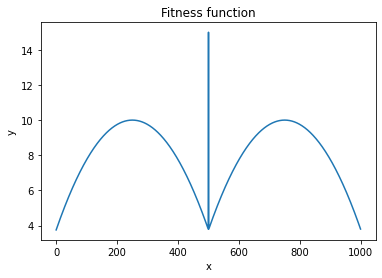

In [3]:
# Problem 1: Sharp Global Peak
def f1(x):
    """
    Fitness must be non-negative, as mlrose evaluates probability simply as fitness/sum(fitness in population)
    """
    if isinstance(x, np.ndarray):  # For compatibility with (one-element) state vector in mlrose
        assert x.shape == (1,)
        x = x[0]
    assert 0 <= x < 1000
    if 0 <= x < 500:
        return 10 - (x - 250) ** 2 / 10000
    elif x == 500:
        return 15
    else:
        return 10 - (x - 750) ** 2 / 10000
    
plot_fitness_function(f1)

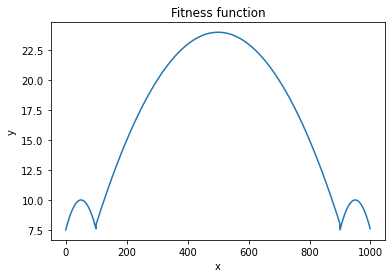

In [4]:
# Problem 2: Wide Basin Global Peak
def f2(x):
    """
    Fitness must be non-negative, as mlrose evaluates probability simply as fitness/sum(fitness in population)
    """
    if isinstance(x, np.ndarray):  # For compatibility with (one-element) state vector in mlrose
        assert x.shape == (1,)
        x = x[0]
    assert 0 <= x < 1000
    if 0 <= x < 100:
        return 10 - (x - 50) ** 2 / 1000
    elif x < 900:
        return 24 - (x - 500) ** 2 / 10000
    else:
        return 10 - (x - 950) ** 2 / 1000
    
plot_fitness_function(f2)

In [5]:
# Problem 3: 0-1 Knapsack Problem
# Reference: https://mlrose.readthedocs.io/en/stable/source/fitness.html#mlrose.fitness.Knapsack
# Best solution from Dynamic Programming: max total value = 7733
values = [
    360, 83, 59, 130, 431, 67, 230, 52, 93, 125, 670, 892, 600, 38, 48, 147,
    78, 256, 63, 17, 120, 164, 432, 35, 92, 110, 22, 42, 50, 323, 514, 28,
    87, 73, 78, 15, 26, 78, 210, 36, 85, 189, 274, 43, 33, 10, 19, 389, 276,
    312
]
weights = [
    7, 1, 30, 22, 80, 94, 11, 81, 70, 64, 59, 18, 1, 36, 3, 8, 15, 42, 9, 1,
    42, 47, 52, 32, 26, 48, 55, 6, 29, 84, 2, 4, 18, 56, 7, 29, 93, 44, 71,
    3, 86, 66, 31, 65, 1, 79, 20, 65, 52, 13
]
max_weight_pct = 0.5
f3 = mlrose.Knapsack(weights, values, max_weight_pct)

## Apply each algorithm on each problem

In [6]:
def plot_fitness_curve(fitness_curve):
    iters = list(range(1, len(fitness_curve) + 1))
    plt.plot(iters, fitness_curve)
    plt.title('Fitness curve')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.show()

In [7]:
def randomized_optimization(fitness_func, algorithm):
    if isinstance(fitness_func, mlrose.fitness.Knapsack):
        problem = mlrose.DiscreteOpt(
            length=len(fitness_func.weights),
            fitness_fn=fitness_func,
            maximize=True,
            max_val=2,  # Limit to 0-1 Knapsack Problem
        )
    else:
        fitness = mlrose.CustomFitness(fitness_func)
        problem = mlrose.DiscreteOpt(length=1, fitness_fn=fitness, maximize=True, max_val=1000)
    if algorithm == 'random-hill-climb':
        best_state, best_fitness, fitness_curve = mlrose.random_hill_climb(
            problem,
            restarts=10,
            max_attempts=10,
            max_iters=1000,
            init_state=np.zeros(problem.length),
            random_state=1,
            curve=True,
        )
    elif algorithm == 'simulated-annealing':
        best_state, best_fitness, fitness_curve = mlrose.simulated_annealing(
            problem,
            schedule=mlrose.ExpDecay(),
            max_attempts=10,
            max_iters=1000,
            init_state=np.zeros(problem.length),
            random_state=1,
            curve=True,
        )
    elif algorithm == 'genetic-alg':
        best_state, best_fitness, fitness_curve = mlrose.genetic_alg(
            problem,
            pop_size=200,
            mutation_prob=0.4,  # Should be reasonably high to reach the sharp peak in Problem 1
            max_attempts=10,
            max_iters=1000,
            random_state=1,
            curve=True,
        )
    elif algorithm == 'mimic':
        best_state, best_fitness, fitness_curve = mlrose.mimic(
            problem,
            pop_size=200,
            keep_pct=0.2,
            max_attempts=10,
            max_iters=1000,
            random_state=1,
            curve=True,
        )
    else:
        raise ValueError('Algorithm {} is not supported!'.format(algoritm))
    print('Best state = {}'.format(best_state))
    print('Best fitness = {}'.format(best_fitness))
    plot_fitness_curve(fitness_curve)

-------------------------------------------------------------
Result for algorithm random-hill-climb applied on problem 1
-------------------------------------------------------------
Best state = [750.]
Best fitness = 10.0


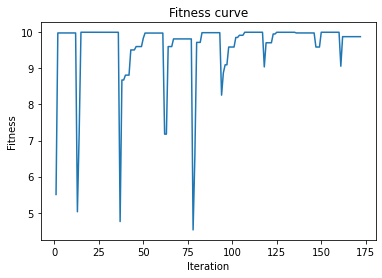

-------------------------------------------------------------
Result for algorithm simulated-annealing applied on problem 1
-------------------------------------------------------------
Best state = [728.]
Best fitness = 9.9516


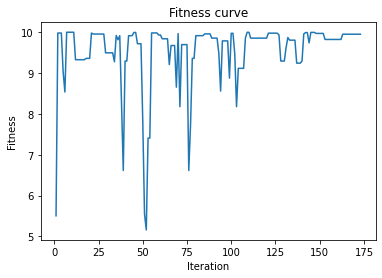

-------------------------------------------------------------
Result for algorithm genetic-alg applied on problem 1
-------------------------------------------------------------
Best state = [500]
Best fitness = 15.0


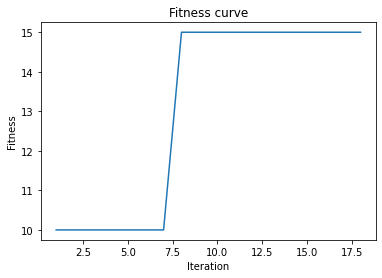

-------------------------------------------------------------
Result for algorithm mimic applied on problem 1
-------------------------------------------------------------
Best state = [749]
Best fitness = 9.9999


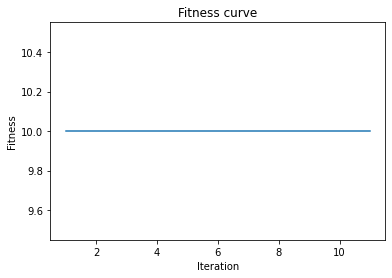

-------------------------------------------------------------
Result for algorithm random-hill-climb applied on problem 2
-------------------------------------------------------------
Best state = [497.]
Best fitness = 23.9991


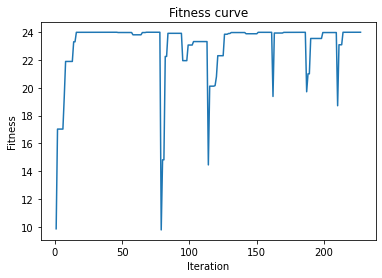

-------------------------------------------------------------
Result for algorithm simulated-annealing applied on problem 2
-------------------------------------------------------------
Best state = [490.]
Best fitness = 23.99


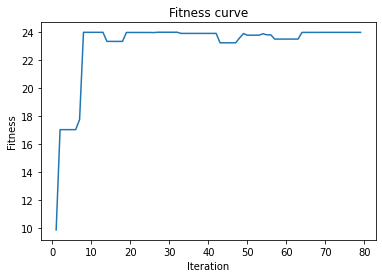

-------------------------------------------------------------
Result for algorithm genetic-alg applied on problem 2
-------------------------------------------------------------
Best state = [501]
Best fitness = 23.9999


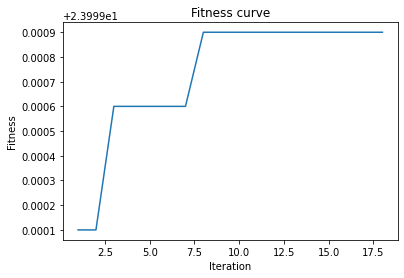

-------------------------------------------------------------
Result for algorithm mimic applied on problem 2
-------------------------------------------------------------
Best state = [503]
Best fitness = 23.9991


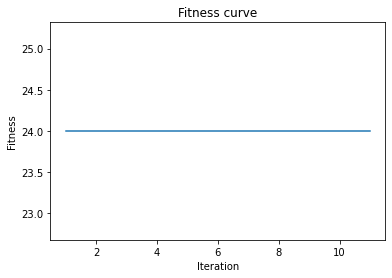

-------------------------------------------------------------
Result for algorithm random-hill-climb applied on problem 3
-------------------------------------------------------------
Best state = [1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 0.]
Best fitness = 5775.0


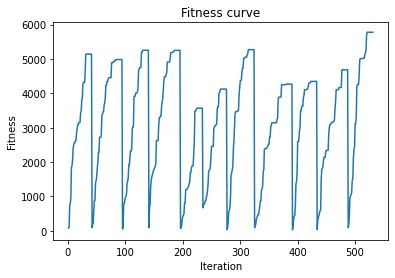

-------------------------------------------------------------
Result for algorithm simulated-annealing applied on problem 3
-------------------------------------------------------------
Best state = [1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 1.]
Best fitness = 5735.0


/usr/local/lib/python3.8/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


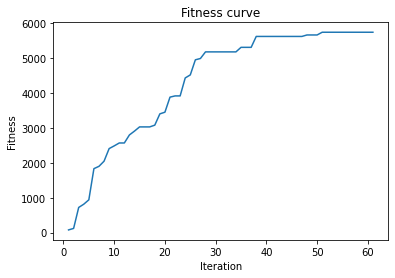

-------------------------------------------------------------
Result for algorithm genetic-alg applied on problem 3
-------------------------------------------------------------
Best state = [1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 0 1 1 1 1]
Best fitness = 7037.0


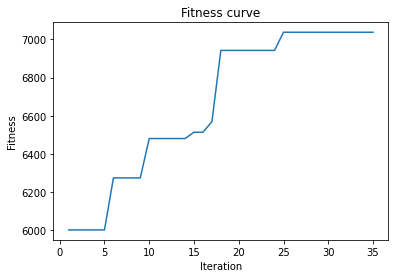

-------------------------------------------------------------
Result for algorithm mimic applied on problem 3
-------------------------------------------------------------
Best state = [1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0
 0 0 1 0 1 1 0 1 0 0 1 1 1]
Best fitness = 7597.0


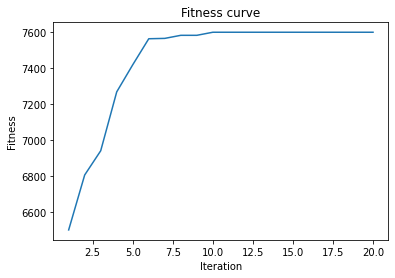

In [8]:
fitness_funcs = [f1, f2, f3]
algorithms = ['random-hill-climb', 'simulated-annealing', 'genetic-alg', 'mimic']
for i, fitness_func in enumerate(fitness_funcs):
    for algorithm in algorithms:
        print('-------------------------------------------------------------')
        print('Result for algorithm {0} applied on problem {1}'.format(algorithm, i + 1))
        print('-------------------------------------------------------------')
        randomized_optimization(fitness_func, algorithm)